Questo notebook è tratto da un esempio del libro HuggingFace in Action e dimostra come utilizzare la funzionalità "base" di Object Detection su immagini.

Oltre alla libreria transformer è necessario utilizzare la libreria Timm (https://timm.fast.ai)

Prima viene utilizzato il modello direttamente mentre successivamente verrà utilizzata la pipeline

In [9]:
from transformers import DetrImageProcessor, DetrForObjectDetection

# Modulo per pre-processare l'immagine che andrà in input al modello x Object DEtection
image_processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")

# Modello pretrained per Object Detection
model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50")

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Per visualizzare gli oggetti per il quali il modello è stato addestrato ad identificare in fase di training

In [2]:
model.config.id2label

{0: 'N/A',
 1: 'person',
 10: 'traffic light',
 11: 'fire hydrant',
 12: 'street sign',
 13: 'stop sign',
 14: 'parking meter',
 15: 'bench',
 16: 'bird',
 17: 'cat',
 18: 'dog',
 19: 'horse',
 2: 'bicycle',
 20: 'sheep',
 21: 'cow',
 22: 'elephant',
 23: 'bear',
 24: 'zebra',
 25: 'giraffe',
 26: 'hat',
 27: 'backpack',
 28: 'umbrella',
 29: 'shoe',
 3: 'car',
 30: 'eye glasses',
 31: 'handbag',
 32: 'tie',
 33: 'suitcase',
 34: 'frisbee',
 35: 'skis',
 36: 'snowboard',
 37: 'sports ball',
 38: 'kite',
 39: 'baseball bat',
 4: 'motorcycle',
 40: 'baseball glove',
 41: 'skateboard',
 42: 'surfboard',
 43: 'tennis racket',
 44: 'bottle',
 45: 'plate',
 46: 'wine glass',
 47: 'cup',
 48: 'fork',
 49: 'knife',
 5: 'airplane',
 50: 'spoon',
 51: 'bowl',
 52: 'banana',
 53: 'apple',
 54: 'sandwich',
 55: 'orange',
 56: 'broccoli',
 57: 'carrot',
 58: 'hot dog',
 59: 'pizza',
 6: 'bus',
 60: 'donut',
 61: 'cake',
 62: 'chair',
 63: 'couch',
 64: 'potted plant',
 65: 'bed',
 66: 'mirror',
 67

Definisco una funzione di utilità per caricare un'immagine (da rete o da file system)

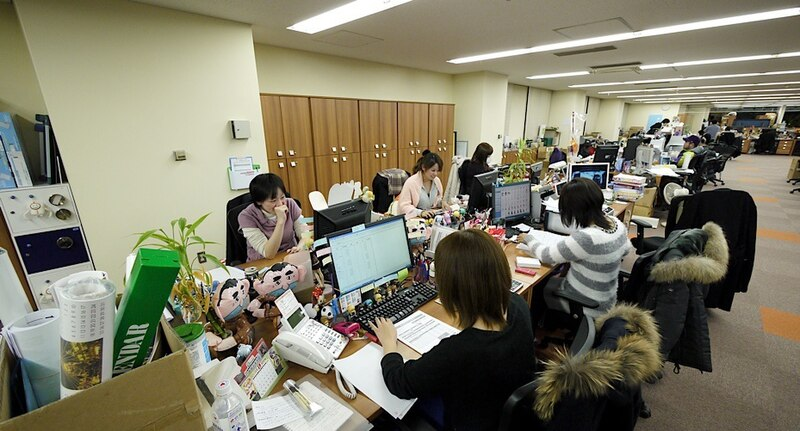

In [10]:
from PIL import Image, ImageDraw
import requests
import torch

def loadImage(url):
    if url.startswith('http'):  #1
        image = Image.open(requests.get(url, stream=True).raw)
    else:
        image = Image.open(url)  #2
    return image

image = loadImage('Good_Smile_Company_offices_ladies.jpg')
display(image)

Utilizzo il modulo precedentemente istanziato per effettuare il pre-processing dell'immagine. L'output è costituito da un tensor Pytorch

In [12]:
inputs = image_processor(images = image, return_tensors = "pt")

In [13]:
inputs

{'pixel_values': tensor([[[[-1.1247, -1.1247, -1.1075,  ..., -0.4397, -0.4568, -0.4568],
          [-1.1589, -1.1589, -1.1418,  ..., -0.4397, -0.4397, -0.4397],
          [-1.2103, -1.2103, -1.1932,  ..., -0.4397, -0.4226, -0.4226],
          ...,
          [-0.4226, -0.4568, -0.4911,  ..., -0.5253, -0.5767, -0.6109],
          [-0.3027, -0.3369, -0.3712,  ..., -0.5938, -0.5596, -0.5596],
          [-0.2342, -0.2684, -0.3027,  ..., -0.6281, -0.5596, -0.5253]],

         [[-1.0378, -1.0378, -1.0203,  ..., -0.4251, -0.4426, -0.4426],
          [-1.0728, -1.0728, -1.0553,  ..., -0.4251, -0.4251, -0.4251],
          [-1.1253, -1.1253, -1.1078,  ..., -0.4251, -0.4076, -0.4076],
          ...,
          [-0.5476, -0.5826, -0.6176,  ..., -0.4426, -0.4951, -0.5301],
          [-0.4601, -0.4951, -0.5301,  ..., -0.5126, -0.4776, -0.4776],
          [-0.4076, -0.4426, -0.4776,  ..., -0.5476, -0.4776, -0.4426]],

         [[-1.2990, -1.2990, -1.2816,  ..., -0.4450, -0.4624, -0.4624],
          [-1

Passo questo pytorch tensor al modello per fare un forward pass e ottenere l'output

In [14]:
outputs = model(**inputs)

L'ouput ottenuto deve poi essere post processato per eliminare le prediction con confidenza inferiore al 90% e ritornare un dictionary con le immagini individuate e i relativi boxes

In [15]:
target_sizes = torch.tensor([image.size[::-1]])

results = image_processor.post_process_object_detection(
              outputs,
              target_sizes = target_sizes,
              threshold = 0.9)[0]
results

{'scores': tensor([0.9259, 0.9962, 0.9084, 0.9665, 0.9644, 0.9901, 0.9901, 0.9980, 0.9556,
         0.9987, 0.9198, 0.9900, 0.9997, 0.9900, 0.9963],
        grad_fn=<IndexBackward0>),
 'labels': tensor([ 1, 72, 72,  1,  1,  1, 76,  1, 72,  1,  1, 64,  1, 72,  1]),
 'boxes': tensor([[549.7345, 145.7127, 564.3798, 165.0533],
         [319.3237, 212.7904, 415.4410, 299.9366],
         [468.6755, 168.1436, 498.7116, 209.0749],
         [673.5676, 135.7153, 704.7078, 172.6653],
         [702.7293, 115.9515, 721.3703, 139.5370],
         [454.9215, 142.3894, 497.1141, 205.4864],
         [344.9012, 278.5276, 443.5710, 344.4696],
         [394.7351, 151.7581, 445.9789, 217.2949],
         [310.0593, 194.0169, 374.9794, 237.0317],
         [237.2554, 173.7091, 308.1720, 265.0474],
         [718.7568, 112.8772, 737.2061, 131.4151],
         [125.0226, 210.7708, 228.7874, 327.9577],
         [367.0159, 226.6126, 535.3434, 427.8178],
         [492.0173, 180.4687, 531.0073, 223.7060],
         [51

Infine riscrivo l'immagine originale con disegnando i boxes con le rispettive label

Detected person with confidence 92.59% at [549.73, 145.71, 564.38, 165.05]
Detected tv with confidence 99.62% at [319.32, 212.79, 415.44, 299.94]
Detected tv with confidence 90.84% at [468.68, 168.14, 498.71, 209.07]
Detected person with confidence 96.65% at [673.57, 135.72, 704.71, 172.67]
Detected person with confidence 96.44% at [702.73, 115.95, 721.37, 139.54]
Detected person with confidence 99.01% at [454.92, 142.39, 497.11, 205.49]
Detected keyboard with confidence 99.01% at [344.9, 278.53, 443.57, 344.47]
Detected person with confidence 99.80% at [394.74, 151.76, 445.98, 217.29]
Detected tv with confidence 95.56% at [310.06, 194.02, 374.98, 237.03]
Detected person with confidence 99.87% at [237.26, 173.71, 308.17, 265.05]
Detected person with confidence 91.98% at [718.76, 112.88, 737.21, 131.42]
Detected potted plant with confidence 99.00% at [125.02, 210.77, 228.79, 327.96]
Detected person with confidence 99.97% at [367.02, 226.61, 535.34, 427.82]
Detected tv with confidence 99

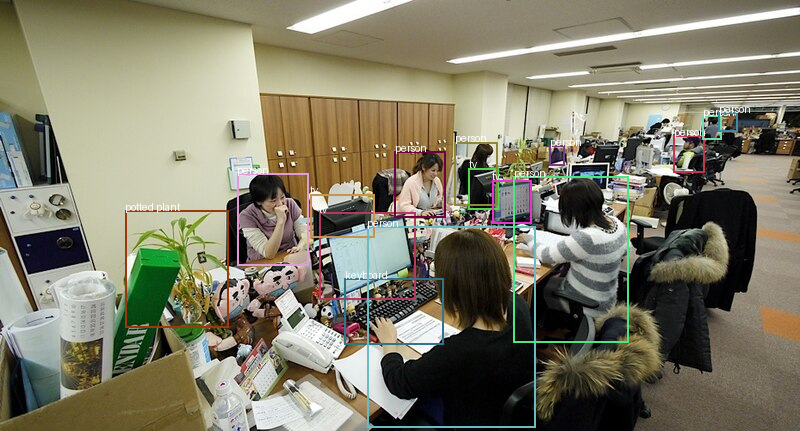

In [16]:
import random

draw = ImageDraw.Draw(image)

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    print(
        f"Detected {model.config.id2label[label.item()]} with confidence "
        f"{(score.item() * 100):.2f}% at {box}"
    )

    r = random.randint(0, 255)
    g = random.randint(0, 255)
    b = random.randint(0, 255)
    color = (r, g, b)

    draw.rectangle(box,  #1
                   outline=color,   #1
                   width=2)   #1

    draw.text((box[0], box[1]-10),  #2
              model.config.id2label[label.item()],   #2
              fill='white')   #2

display(image)

Lo stesso risultato si può ottenere utilizzando la pipeline

In [17]:
from transformers import pipeline

detection = pipeline("object-detection", model="facebook/detr-resnet-50")

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Using a slow image processor as `use_fast` is unset and a slow processor was saved w

Output della pipeline è una lista dictionary per ogni oggetto individuato.

In [18]:
results = detection(image)
results

[{'score': 0.5321298837661743,
  'label': 'tv',
  'box': {'xmin': 549, 'ymin': 144, 'xmax': 566, 'ymax': 165}},
 {'score': 0.5014099478721619,
  'label': 'chair',
  'box': {'xmin': 654, 'ymin': 180, 'xmax': 690, 'ymax': 215}},
 {'score': 0.5179111957550049,
  'label': 'laptop',
  'box': {'xmin': 571, 'ymin': 166, 'xmax': 607, 'ymax': 188}},
 {'score': 0.7310990691184998,
  'label': 'bottle',
  'box': {'xmin': 205, 'ymin': 379, 'xmax': 247, 'ymax': 430}},
 {'score': 0.9765108227729797,
  'label': 'person',
  'box': {'xmin': 457, 'ymin': 143, 'xmax': 495, 'ymax': 202}},
 {'score': 0.7319640517234802,
  'label': 'tv',
  'box': {'xmin': 594, 'ymin': 144, 'xmax': 619, 'ymax': 166}},
 {'score': 0.6217063665390015,
  'label': 'suitcase',
  'box': {'xmin': 314, 'ymin': 193, 'xmax': 370, 'ymax': 235}},
 {'score': 0.7577230334281921,
  'label': 'sports ball',
  'box': {'xmin': 209, 'ymin': 274, 'xmax': 250, 'ymax': 324}},
 {'score': 0.8205579519271851,
  'label': 'tv',
  'box': {'xmin': 469, 'ym

Per visualizzare l'immagine con i relativi bounding box devo usare la seguente funzione (leggermente diversa da quella usata in precedenza per gestire il diverso formato di input)

Detected tv with confidence 53.21% at [549, 144, 566, 165]
Detected chair with confidence 50.14% at [654, 180, 690, 215]
Detected laptop with confidence 51.79% at [571, 166, 607, 188]
Detected bottle with confidence 73.11% at [205, 379, 247, 430]
Detected person with confidence 97.65% at [457, 143, 495, 202]
Detected tv with confidence 73.20% at [594, 144, 619, 166]
Detected suitcase with confidence 62.17% at [314, 193, 370, 235]
Detected sports ball with confidence 75.77% at [209, 274, 250, 324]
Detected tv with confidence 82.06% at [469, 170, 496, 207]
Detected person with confidence 99.79% at [397, 154, 444, 212]
Detected person with confidence 99.87% at [239, 175, 307, 265]
Detected person with confidence 52.36% at [702, 118, 723, 141]
Detected tv with confidence 95.73% at [226, 186, 307, 269]
Detected person with confidence 80.34% at [649, 115, 671, 134]
Detected remote with confidence 62.61% at [273, 334, 325, 371]
Detected potted plant with confidence 97.49% at [129, 210, 224, 3

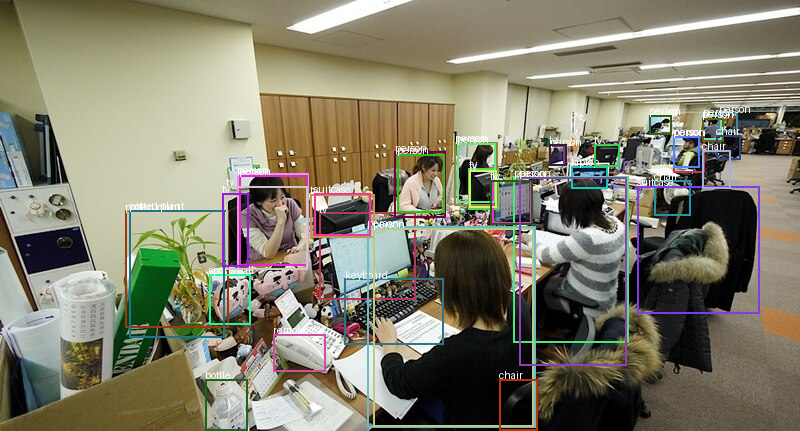

In [19]:
import random

draw = ImageDraw.Draw(image)

for object in results:
    box = [i for i in object['box'].values()]
    print(
        f"Detected {object['label']} with confidence "
        f"{(object['score'] * 100):.2f}% at {box}"
    )

    r = random.randint(0, 255)
    g = random.randint(0, 255)
    b = random.randint(0, 255)
    color = (r, g, b)

    draw.rectangle(box,  #1
                   outline=color,   #1
                   width=2)   #1

    draw.text((box[0], box[1]-10),  #2
              object['label'],   #2
              fill='white')   #2

display(image)